In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from sklearn.metrics import mean_squared_error

from tensorflow import keras

from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.10.0
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.4
sklearn 1.1.2
tensorflow 2.10.0
keras.api._v2.keras 2.10.0


* 添加高空层次, 特别是逆温的判别
* 自定义损失函数

In [2]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  root_dir = "F:/github/pythonScript/seafog/"
else:
  root_dir = "H:/github/python/seafog/"

In [28]:
def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

def reverse_linear_vis(x):
    if(x<0):
      y = 1
    elif(x <= 1.0):
      y = x*1000.0
    elif(x <= 2.0):
      y = (x - 1.0)*9000.0 + 1000.0
    elif(x <= 3.0):
      y = (x-2.0)*20000 + 10000.0
    else:
      y = 30000.0
    return y

def setDataset(df, x_columns):
    df['t_td'] =  df['t2mm'] - df['t2md']
    df['td_sst'] =  df['t2md'] - df['sstk']
    df['t_sst'] =  df['t2mm'] - df['sstk']
    df['delta_theta'] = df['theta925'] - df['theta1000']
    df['delta_theta_e'] = df['theta_e925'] - df['theta_e1000']
    df_x = df.loc[:, x_columns]
    df_y = df['station_vis_linear']
    _x = df_x.to_numpy()
    _y = df_y.to_numpy()
    return (_x, _y)

def getScore(x,y, model):
    predictions = model(x).numpy()
    y_p = predictions[:,0]
    df_s = pd.DataFrame({'prediction':y_p, 'y':y})
    df_s_fog = df_s.loc[df_s['y']<=1.0]
    df_s_mist = df_s.loc[(df_s['y']>1.0) & (df_s['y']<=2.0)]
    df_s_clear = df_s.loc[df_s['y']>2.0]
    print('* 实况为雾时:', end=' ')
    getLevelRatio(df_s_fog)
    # print('-------------')
    print('* 实况为轻雾时:', end=' ')
    # print('-------------')
    getLevelRatio(df_s_mist)
    print('* 实况为无雾时:', end=' ')
    getLevelRatio(df_s_clear)
    print('* TS评分:', end=' ')
    TS_fog = get_fog_TSscore(df_s, threshold=1.0)
    TS_fog_mist = get_fog_TSscore(df_s, threshold=2.0)
    print(f'雾: {TS_fog}, 轻雾及雾: {TS_fog_mist}')

def getLevelRatio(df):
    length = len(df)
    ratio_fog = len(df.loc[df['prediction']<=1.0])/length
    ratio_mist = len(df.loc[(df['prediction']>1.0) & (df['prediction']<=2.0)])/length
    ratio_clear = len(df.loc[df['prediction']>2.0])/length
    print(f'比例: 雾:{ratio_fog}, 轻雾{ratio_mist}, 无雾{ratio_clear}')
    return (ratio_fog, ratio_mist, ratio_clear)

def get_fog_TSscore(df, threshold=1.0):
    length = len(df)
    NA = len(df.loc[(df['prediction']<=threshold) & (df['y']<=threshold)]) # 正确数
    NB = len(df.loc[(df['prediction']<=threshold) & (df['y']>threshold)]) # 空报数
    NC = len(df.loc[(df['prediction']>threshold) & (df['y']<=threshold)]) # 空报数
    TS_score = NA/(NA + NB + NC)
    return TS_score

def get_NWP_score(df):
    y = df['station_vis'].apply(linear_vis)
    y_p = df['visi'].apply(linear_vis)
    df_s = pd.DataFrame({'prediction':y_p, 'y':y})
    df_s.dropna(inplace=True)
    df_s_fog = df_s.loc[df_s['y']<=1.0]
    df_s_mist = df_s.loc[(df_s['y']>1.0) & (df_s['y']<=2.0)]
    df_s_clear = df_s.loc[df_s['y']>2.0]
    print('* 实况为雾时:', end=' ')
    getLevelRatio(df_s_fog)
    # print('-------------')
    print('* 实况为轻雾时:', end=' ')
    # print('-------------')
    getLevelRatio(df_s_mist)
    print('* 实况为无雾时:', end=' ')
    getLevelRatio(df_s_clear)
    print('* TS评分:', end=' ')
    TS_fog = get_fog_TSscore(df_s, threshold=1.0)
    TS_fog_mist = get_fog_TSscore(df_s, threshold=2.0)
    print(f'雾: {TS_fog}, 轻雾及雾: {TS_fog_mist}')

In [19]:
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "F:/github/pythonScript/seafog/data/collection/fog_dataset.hdf"
# fog_dataset_hdf = "H:/github/python/seafog/data/collection/fullhour/fog_dataset_fulltime.hdf"
# fog_dataset_hdf = os.path.normpath(os.path.join(file_dir, './fullhour/fog_dataset_72h1_168h6.hdf'))
# fog_dataset_hdf = os.path.normpath(os.path.join(root_dir, './data/collection/fog_dataset_allstation.h5'))
# fog_dataset_hdf = os.path.normpath(os.path.join(root_dir, './data/collection/fog_dataset_hdf66_fc120h.h5'))
fog_dataset_hdf = os.path.normpath(os.path.join(root_dir, './data/collection/fog_dataset_hdf66_fc120h_v2.h5'))
store_dataset = pd.HDFStore(fog_dataset_hdf, mode='r')
print(store_dataset.keys())
df_train = store_dataset.get('train')
df_valid =store_dataset.get('valid')
df_test = store_dataset.get('test')
df_valid_test = store_dataset.get('valid_test')

real_fcHour_list = list(range(0, 72+1, 3)) + list(range(78, 168+1, 6))
df_test_real = df_test.loc[df_test['fc_hour'].isin(real_fcHour_list) ].copy(deep=True)
df_valid_test_real = df_valid_test.loc[df_valid_test['fc_hour'].isin(real_fcHour_list) ].copy(deep=True)

x_columns = ['t_td', 'td_sst','t_sst','v100', 'v10m', 'u100', 'u10m', 't2mm', 't2md', 'sstk','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e','theta_e925']

(train_x, train_y) = setDataset(df_train, x_columns)
(valid_x, valid_y) = setDataset(df_valid, x_columns)
(test_x,  test_y)  = setDataset(df_test, x_columns)
(valid_test_x, valid_test_y) = setDataset(df_valid_test, x_columns)

(test_real_x,  test_real_y)  = setDataset(df_test_real, x_columns)
(valid_test_real_x, valid_test_real_y) = setDataset(df_valid_test_real, x_columns)



print(train_x.shape)
print(train_y.shape)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled  = scaler.transform(test_x)
valid_x_scaled = scaler.transform(valid_x)
valid_test_x_scaled = scaler.transform(valid_test_x)

test_x_real_scaled  = scaler.transform(test_real_x)
valid_test_x_real_scaled = scaler.transform(valid_test_real_x)


keep_cols = ['t_td', 'td_sst','t_sst','year_sin','year_cos', 'day_sin', 'day_cos','delta_theta','delta_theta_e'] # 不需要标准化变量的参数

for iColumn in keep_cols:
    index = x_columns.index(iColumn)
    train_x_scaled[:,index] = train_x[:,index]
    valid_x_scaled[:,index] = valid_x[:,index]
    test_x_scaled[:,index]  = test_x[:,index]
    valid_test_x_scaled[:,index]  = valid_test_x[:,index]

    test_x_real_scaled[:,index]  = test_real_x[:,index]
    valid_test_x_real_scaled[:,index]  = valid_test_real_x[:,index]


['/test', '/train', '/valid', '/valid_test']
(469269, 17)
(469269,)


C:\Users\Henry\AppData\Local\Temp\ipykernel_11744\4157146657.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['t_td'] =  df['t2mm'] - df['t2md']
C:\Users\Henry\AppData\Local\Temp\ipykernel_11744\4157146657.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['td_sst'] =  df['t2md'] - df['sstk']
C:\Users\Henry\AppData\Local\Temp\ipykernel_11744\4157146657.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [7]:
print(df_train.columns)

Index(['sstk', 't2md', 't2mm', 'u100', 'u10m', 'v100', 'v10m', 'visi',
       'rhum1000', 'rhum950', 'rhum925', 'rhum900', 'rhum850', 'temp1000',
       'temp950', 'temp925', 'temp900', 'temp850', 'theta_e1000', 'theta1000',
       'theta_e950', 'theta950', 'theta_e925', 'theta925', 'theta_e900',
       'theta900', 'theta_e850', 'theta850', 'actual_time', 'init_time',
       'year', 'month', 'day', 'hour', 'year_sin', 'year_cos', 'day_sin',
       'day_cos', 'station_vis', 'station_rain1', 'fc_hour', 'station_vis_cat',
       'station_vis_linear', 't_td', 'td_sst', 't_sst', 'delta_theta',
       'delta_theta_e'],
      dtype='object')


In [4]:
train_x[:,0:3]

array([[ 0.81814575, -0.06332397,  0.75482178],
       [ 1.75466919,  2.48303223,  4.23770142],
       [ 4.84399414, -6.36135864, -1.5173645 ],
       ...,
       [ 1.10165405,  1.76098633,  2.86264038],
       [ 0.89828491, -1.16769409, -0.26940918],
       [ 4.4621582 , -4.43380737,  0.02835083]])

In [5]:
# tf.keras.models.Sequential()

"""
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))
"""

model = keras.models.Sequential([
    keras.layers.Dense(60, activation='relu',
                       input_shape=train_x_scaled.shape[1:]),                 
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1),
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[] 
model.compile(loss="mean_squared_error", optimizer="sgd")

In [21]:
train_x_scaled.shape[1:]

(18,)

In [6]:
model.layers

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                1080      
                                                                 
 dense_1 (Dense)             (None, 8)                 488       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,577
Trainable params: 1,577
Non-trainable params: 0
_________________________________________________________________


In [28]:
# [None, 784] * W + b -> [None, 300] W.shape [784, 300], b = [300]

In [8]:
# H:/github/python/seafog/
logdir = './callbacks_reg_hdf66_fc120h_v2'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "sea_fog_reg_model.h5")

model_callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-4),
    ]
history = model.fit(train_x_scaled, train_y, epochs=50,
                    validation_data=(valid_x_scaled, valid_y),
                    callbacks = model_callbacks)

Epoch 1/50
14665/14665 [==============================] - 43s 3ms/step - loss: 0.1890 - val_loss: 0.2784
Epoch 2/50
14665/14665 [==============================] - 39s 3ms/step - loss: 0.1584 - val_loss: 0.3251
Epoch 3/50
14665/14665 [==============================] - 40s 3ms/step - loss: 0.1492 - val_loss: 0.3098
Epoch 4/50
14665/14665 [==============================] - 40s 3ms/step - loss: 0.1434 - val_loss: 0.3047
Epoch 5/50
14665/14665 [==============================] - 39s 3ms/step - loss: 0.1398 - val_loss: 0.2689
Epoch 6/50
14665/14665 [==============================] - 39s 3ms/step - loss: 0.1367 - val_loss: 0.2876
Epoch 7/50
14665/14665 [==============================] - 38s 3ms/step - loss: 0.1346 - val_loss: 0.2887
Epoch 8/50
14665/14665 [==============================] - 36s 2ms/step - loss: 0.1328 - val_loss: 0.2853
Epoch 9/50
14665/14665 [==============================] - 37s 3ms/step - loss: 0.1312 - val_loss: 0.2758
Epoch 10/50
14665/14665 [==============================

In [30]:
type(history)

keras.callbacks.History

In [31]:
history.history

{'loss': [0.27181410789489746,
  0.2162269502878189,
  0.20206484198570251,
  0.1925283521413803,
  0.18597984313964844,
  0.18091639876365662,
  0.17724815011024475,
  0.1739254891872406,
  0.17204549908638,
  0.1693294197320938,
  0.1668114811182022,
  0.16499128937721252,
  0.16240307688713074,
  0.16165101528167725,
  0.159617617726326,
  0.1589704155921936,
  0.15786832571029663,
  0.15606717765331268,
  0.15443389117717743,
  0.1540553867816925,
  0.1524885594844818,
  0.15154065191745758,
  0.15078327059745789,
  0.15022461116313934,
  0.14926572144031525,
  0.14775942265987396,
  0.14766249060630798,
  0.14648908376693726,
  0.14565707743167877,
  0.1451215296983719,
  0.14447982609272003,
  0.143423393368721,
  0.14311055839061737,
  0.14231562614440918,
  0.14159099757671356,
  0.1416659951210022,
  0.14043711125850677],
 'val_loss': [0.2325286567211151,
  0.2300790399312973,
  0.21362681686878204,
  0.24127879738807678,
  0.2152748852968216,
  0.20334592461585999,
  0.191374

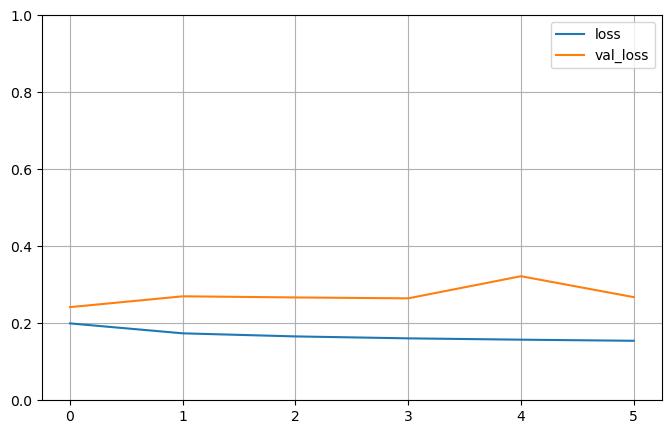

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [9]:
model.evaluate(test_x_scaled, test_y, verbose=0)

0.2003256380558014

* fog_dataset_hdf66_fc120h.h5 => mse 0.2590348422527313
* * fog_dataset_hdf66_fc120h_v2.h5 => mse 0.2003256380558014

* 默认方法MSE 在0.36左右，关键因素是温度和日期
* 添加t-td 等函数后，MSE 在0.3

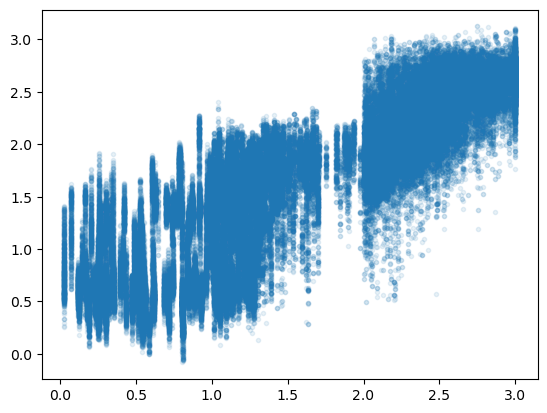

In [10]:
predictions = model(test_x_scaled).numpy()
plt.plot(test_y, predictions,'.', alpha=0.1)
plt.show()

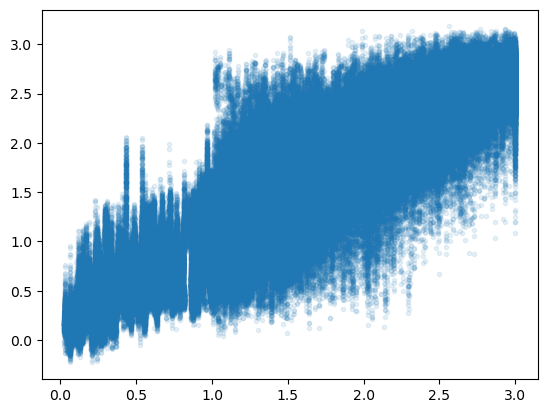

In [11]:
plt.plot(train_y,model(train_x_scaled).numpy(),'.', alpha=0.1)
plt.show()

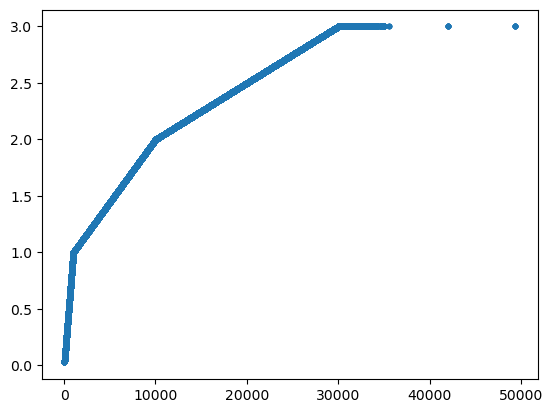

In [12]:
plt.plot(df_train['station_vis'].values,train_y,'.')
plt.show()

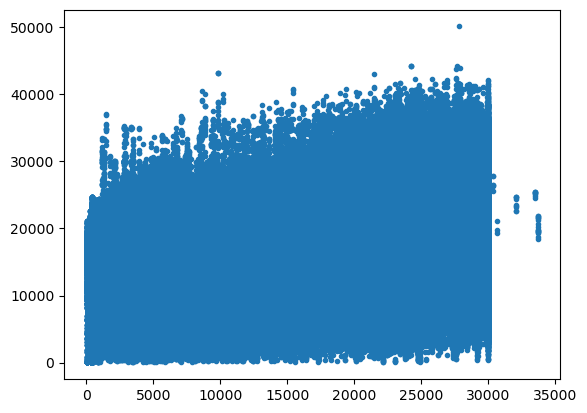

In [13]:
plt.plot(df_train['station_vis'].values,df_train['visi'],'.')
plt.show()

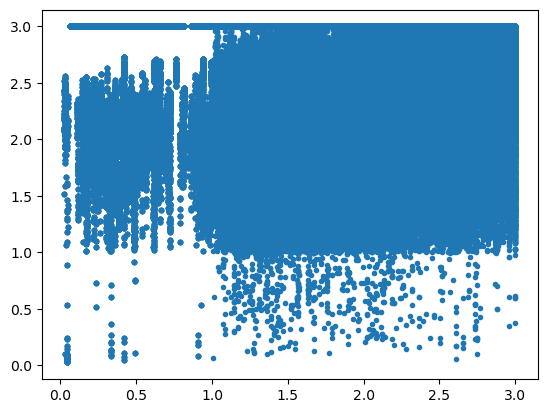

2.0818837368068888


In [14]:
plt.plot(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis),'.')
plt.show()
print(mean_squared_error(df_train['station_vis'].apply(linear_vis),df_train['visi'].apply(linear_vis)))

In [ ]:
p_test = tf.nn.softmax(predictions).numpy()

In [ ]:
p_test[:,0]

In [ ]:
df_p_test = pd.DataFrame({'p_fog':p_test[:,0],'p_mist':p_test[:,1],'p_clear':p_test[:,2]})

In [ ]:
df_p_test['p_clear'].plot()
df_p_test['p_mist'].plot()
df_p_test['p_fog'].plot()

In [ ]:

df_test_result = df_test.join(df_p_test) 
print(df_test_result.head())
df_test_result.to_csv('df_test_result.csv')

In [ ]:
# 各类别预测准确性对比
# 筛选出不同类别 df_all.loc[df_all['station_vis_cat'] == 2]
# 计算输出的类别 

In [ ]:
# print(f'模式评估损失函数{model.evaluate(test_x_scaled, test_y, verbose=0)}')
# predictions = model(test_x_scaled).numpy()
# plt.scatter(test_y, predictions, marker='o',  alpha=0.5)
# plt.title('标准化能见度实况 VS 预报')
# plt.show()
# r,p = pearsonr(predictions[:,0],test_y)
# print(f'相关系数{r}, p值为{p:.5f}')

# plt.plot(df_test['station_vis'].values, np.vectorize(reverse_linear_vis)(predictions[:,0]) ,'.')
# plt.show()


def showPredictions(x, y, origin_vis, titlePrefix=''):
    print(f'模式评估损失函数{model.evaluate(x, y, verbose=0)}')
    predictions = model(x).numpy()
    plt.scatter(y, predictions[:,0], marker='o',  alpha=0.3)
    plt.title(f'{titlePrefix} 标准化能见度实况 VS 预报')
    plt.show()
    r,p = pearsonr(predictions[:,0],y)
    print(f'相关系数{r}, p值为{p:.5f}')

    plt.plot(origin_vis, np.vectorize(reverse_linear_vis)(predictions[:,0]) ,'.')
    plt.title(f'{titlePrefix} 能见度实况 VS 预报')
    plt.show()


showPredictions(test_x_scaled, test_y, df_test['station_vis'].values, '测试集')
showPredictions(valid_test_x_scaled, valid_test_y, df_valid_test['station_vis'].values, '测试+验证集')
showPredictions(train_x_scaled, train_y, df_train['station_vis'].values, '训练集')
showPredictions(valid_x_scaled, valid_y, df_valid['station_vis'].values, '验证集')



In [26]:

print('#### ===================测试集==========')
getScore(test_x_scaled, test_y, model)
print('#### ==============测试集+验证集==========')
getScore(valid_test_x_scaled, valid_test_y, model)
print('#### ==================训练集==========')
getScore(train_x_scaled, train_y, model)
print('#### ===============验证集==========')
getScore(valid_x_scaled, valid_y, model)

# print('#### =============real 测试集==========')
# getScore(test_x_real_scaled, test_real_y, model)
# print('#### =========real 测试集+验证集==========')
# getScore(valid_test_x_real_scaled, valid_test_real_y, model)

#### ===================测试集==========
* 实况为雾时: 比例: 雾:0.6136307699192267, 轻雾0.38200613071398204, 无雾0.00436309936679122
* 实况为轻雾时: 比例: 雾:0.20795202828183385, 轻雾0.7350815563958562, 无雾0.056966415322309984
* 实况为无雾时: 比例: 雾:0.0035352292305282705, 轻雾0.24742129639988364, 无雾0.7490434743695881
* TS评分: 雾: 0.5065102964262628, 轻雾及雾: 0.8612651835947596
#### ==============测试集+验证集==========
* 实况为雾时: 比例: 雾:0.6423672875762152, 轻雾0.3535492532304078, 无雾0.004083459193376965
* 实况为轻雾时: 比例: 雾:0.20794316719807573, 轻雾0.7342954634446496, 无雾0.05776136935727471
* 实况为无雾时: 比例: 雾:0.0035800190188510377, 轻雾0.24838619455165856, 无雾0.7480337864294904
* TS评分: 雾: 0.5302146049569681, 轻雾及雾: 0.8606501997098742
#### ==================训练集==========
* 实况为雾时: 比例: 雾:0.8995288416665068, 轻雾0.10023462022848302, 无雾0.00023653810501013278
* 实况为轻雾时: 比例: 雾:0.0928380097555986, 轻雾0.7345211381957896, 无雾0.17264085204861176
* 实况为无雾时: 比例: 雾:0.005114337405624492, 轻雾0.25525657991471845, 无雾0.7396290826796571
* TS评分: 雾: 0.8192785816180966, 轻雾及雾: 0.808

fog_dataset_hdf66_fc120h_v2.h5

#### ===================测试集==========
* 实况为雾时: 比例: 雾:0.6136307699192267, 轻雾0.38200613071398204, 无雾0.00436309936679122
* 实况为轻雾时: 比例: 雾:0.20795202828183385, 轻雾0.7350815563958562, 无雾0.056966415322309984
* 实况为无雾时: 比例: 雾:0.0035352292305282705, 轻雾0.24742129639988364, 无雾0.7490434743695881
* TS评分: 雾: 0.5065102964262628, 轻雾及雾: 0.8612651835947596
#### ==============测试集+验证集==========
* 实况为雾时: 比例: 雾:0.6423672875762152, 轻雾0.3535492532304078, 无雾0.004083459193376965
* 实况为轻雾时: 比例: 雾:0.20794316719807573, 轻雾0.7342954634446496, 无雾0.05776136935727471
* 实况为无雾时: 比例: 雾:0.0035800190188510377, 轻雾0.24838619455165856, 无雾0.7480337864294904
* TS评分: 雾: 0.5302146049569681, 轻雾及雾: 0.8606501997098742
#### ==================训练集==========
* 实况为雾时: 比例: 雾:0.8995288416665068, 轻雾0.10023462022848302, 无雾0.00023653810501013278
* 实况为轻雾时: 比例: 雾:0.0928380097555986, 轻雾0.7345211381957896, 无雾0.17264085204861176
* 实况为无雾时: 比例: 雾:0.005114337405624492, 轻雾0.25525657991471845, 无雾0.7396290826796571
* TS评分: 雾: 0.8192785816180966, 轻雾及雾: 0.8083286667006058
#### ===============验证集==========
* 实况为雾时: 比例: 雾:0.6711044482233957, 轻雾0.3250917390136937, 无雾0.003803812762910588
* 实况为轻雾时: 比例: 雾:0.2079343059160476, 轻雾0.733509352904323, 无雾0.05855634117962946
* 实况为无雾时: 比例: 雾:0.0036248098093618546, 轻雾0.24935111429338583, 无雾0.7470240758972523
* TS评分: 雾: 0.5539180379337729, 轻雾及雾: 0.8600357533022147

In [30]:
print('#### ============模式预报 测试集==========')
get_NWP_score(df_test)
print('#### ========模式预报 测试集+验证集==========')
get_NWP_score(df_valid_test)
print('#### =========模式预报 ==训练集==========')
get_NWP_score(df_train)
print('#### ======模式预报 ===验证集==========')
get_NWP_score(df_valid)

#### ============模式预报 测试集==========
* 实况为雾时: 比例: 雾:0.007115208198151836, 轻雾0.3274338263262703, 无雾0.6654509654755778
* 实况为轻雾时: 比例: 雾:0.006466337010270064, 轻雾0.10142527912648513, 无雾0.8921083838632448
* 实况为无雾时: 比例: 雾:0.003110106728122972, 轻雾0.1274920009844942, 无雾0.8693978922873828
* TS评分: 雾: 0.007047716141042973, 轻雾及雾: 0.2076599140963843
#### ========模式预报 测试集+验证集==========
* 实况为雾时: 比例: 雾:0.007518039939587179, 轻雾0.22184930357442523, 无雾0.7706326564859876
* 实况为轻雾时: 比例: 雾:0.006466409352799686, 轻雾0.10207529227499021, 无雾0.8914582983722101
* 实况为无雾时: 比例: 雾:0.0030318286065894725, 轻雾0.12688929909940147, 无雾0.870078872294009
* TS评分: 雾: 0.00744730367710619, 轻雾及雾: 0.1586486188367659
#### =========模式预报 ==训练集==========
* 实况为雾时: 比例: 雾:0.001994591588193552, 轻雾0.1794748854068775, 无雾0.8185305230049289
* 实况为轻雾时: 比例: 雾:0.002812885573093471, 轻雾0.1960964819751571, 无雾0.8010906324517494
* 实况为无雾时: 比例: 雾:0.0013552994124904905, 轻雾0.1082257724247713, 无雾0.8904189281627383
* TS评分: 雾: 0.001986312271208022, 轻雾及雾: 0.180310

In [31]:
model_path = os.path.join(root_dir, './data/collection/model_singletest_fog_dataset_hdf66_fc120h_v2')
tf.keras.models.save_model(
    model, model_path, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None, save_traces=True
)

INFO:tensorflow:Assets written to: F:/github/pythonScript/seafog/./data/collection/model_singletest_fog_dataset_hdf66_fc120h_v2\assets
